# **Download Dataset**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d asheniranga/leaf-disease-dataset-combination

Dataset URL: https://www.kaggle.com/datasets/asheniranga/leaf-disease-dataset-combination
License(s): GPL-2.0
... resuming from 29360128 bytes (769117165 bytes left) ...
100% 758M/761M [00:44<00:00, 20.6MB/s]
100% 761M/761M [00:44<00:00, 17.2MB/s]


In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dataset.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

# **Import Library**

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

train_dir = "/content/dataset/dataset/train"
test_dir = "/content/dataset/dataset/test"

In [3]:
print(train_dir)
print(test_dir)

/content/dataset/dataset/train
/content/dataset/dataset/test


# **Data Preparation**

In [4]:
list(sorted(os.listdir(train_dir)))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [5]:
list(sorted(os.listdir(test_dir)))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

## **Resize Data dan Split Dataset**

In [7]:
batch_size = 45
img_height = 224
img_width = 224

In [8]:
img_size = (img_height, img_width, 3)

In [9]:
data_training = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2819 files belonging to 4 classes.


In [10]:
data_test = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 533 files belonging to 4 classes.


In [11]:
class_names = data_training.class_names
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


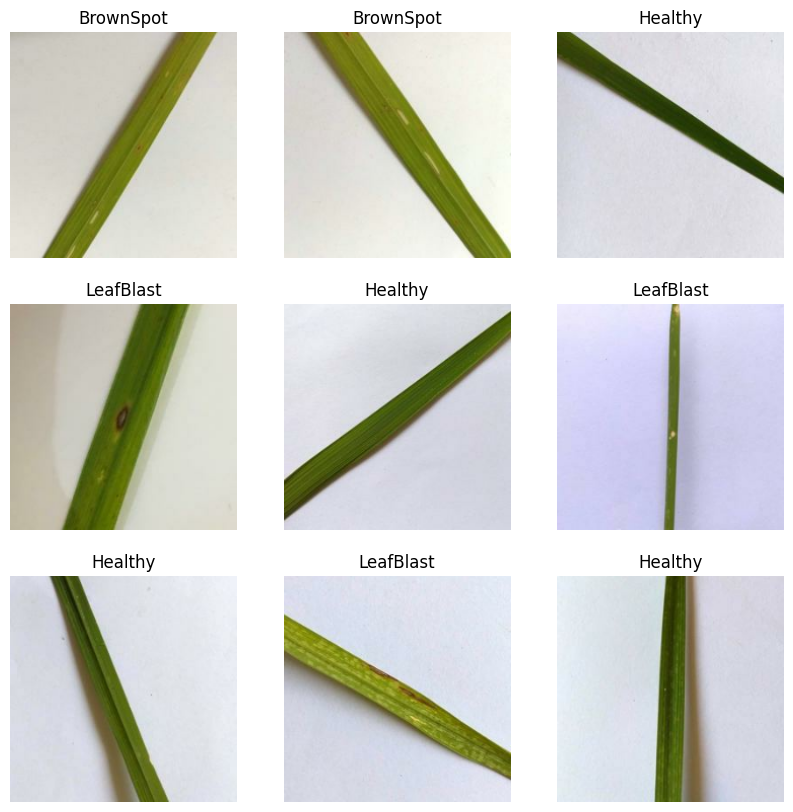

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in data_training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(45, 224, 224, 3)
(45,)


## **Rescalling Pixel**

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

data_train = data_training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
data_test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = data_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9988995


## **Augmentasi Gambar**

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.5),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


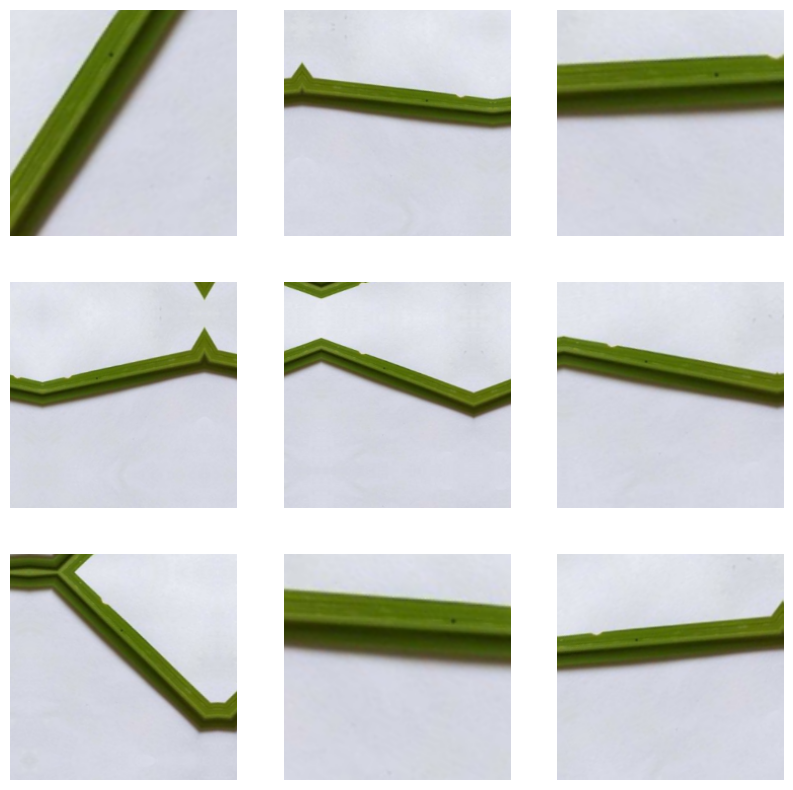

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in data_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Modelling**

## **Import Arsitektur MobileNet V3 Large**

In [16]:
img_size = (224, 224, 3)
MobileNetV3Large  = tf.keras.applications.MobileNetV3Large(input_shape=img_size, include_top=False, weights='imagenet')

MobileNetV3Large.trainable = False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
MobileNetV3Large.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation_20[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu_19[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation_20[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

## **Membangun Model CNN**

In [21]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  MobileNetV3Large,
  layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
  layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.5),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer=tf.keras.optimizers.Lion(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

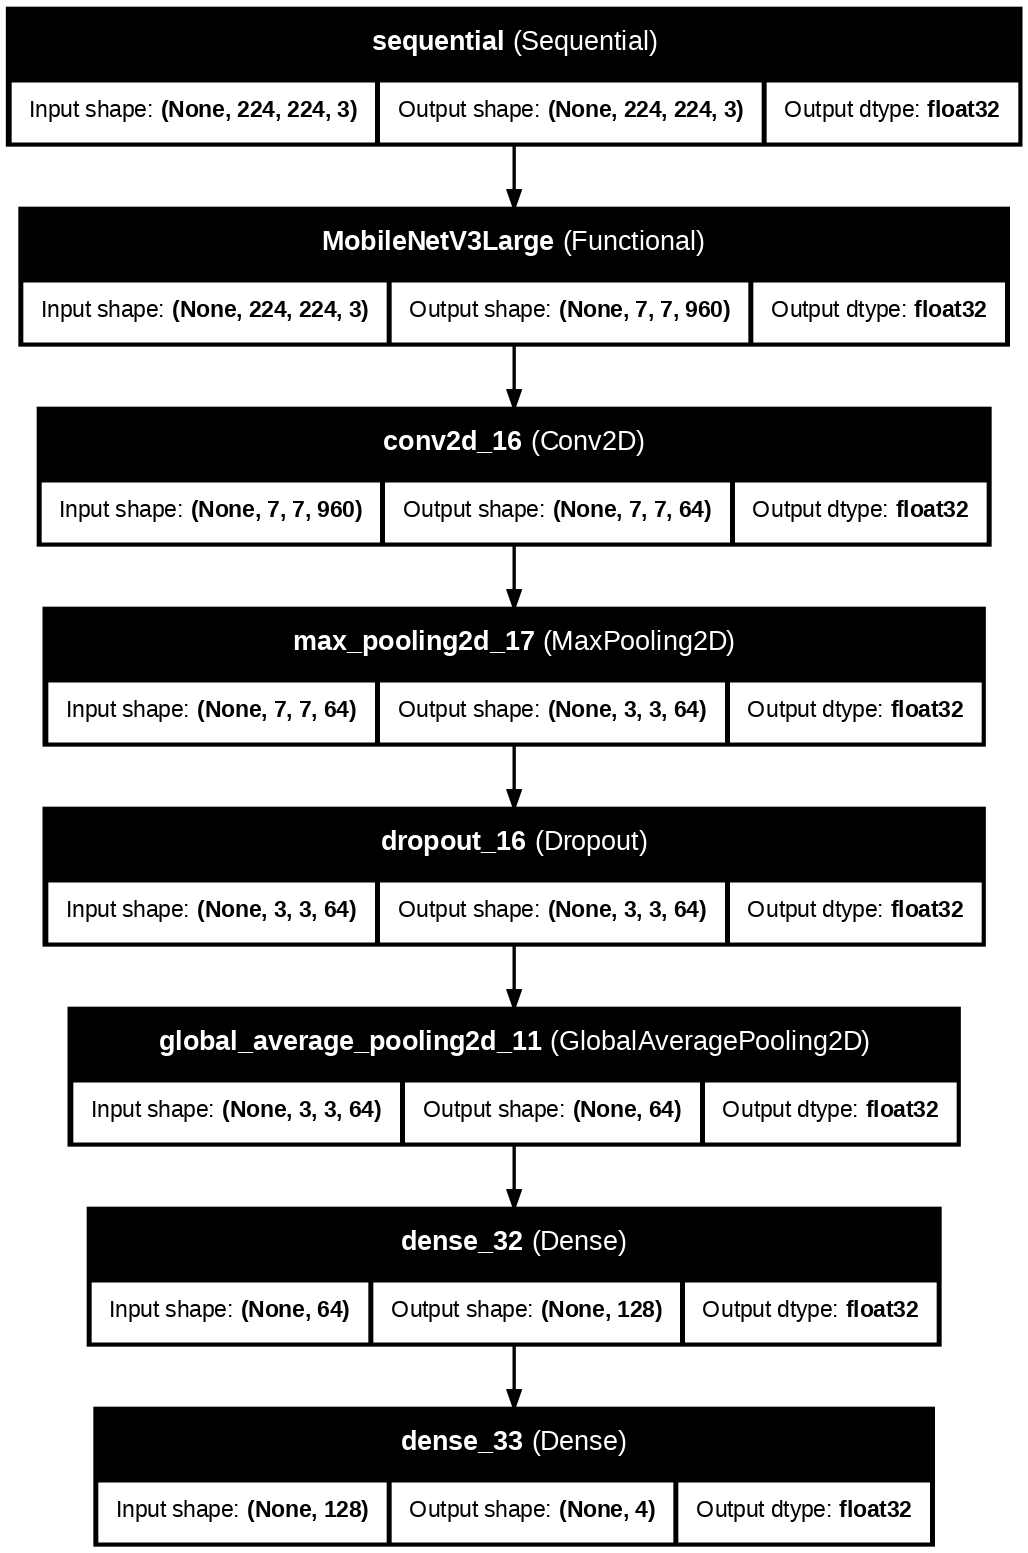

In [ ]:
tf.keras.utils.plot_model(model_1, show_shapes=True, show_layer_names=True, show_dtype=True, dpi=120)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


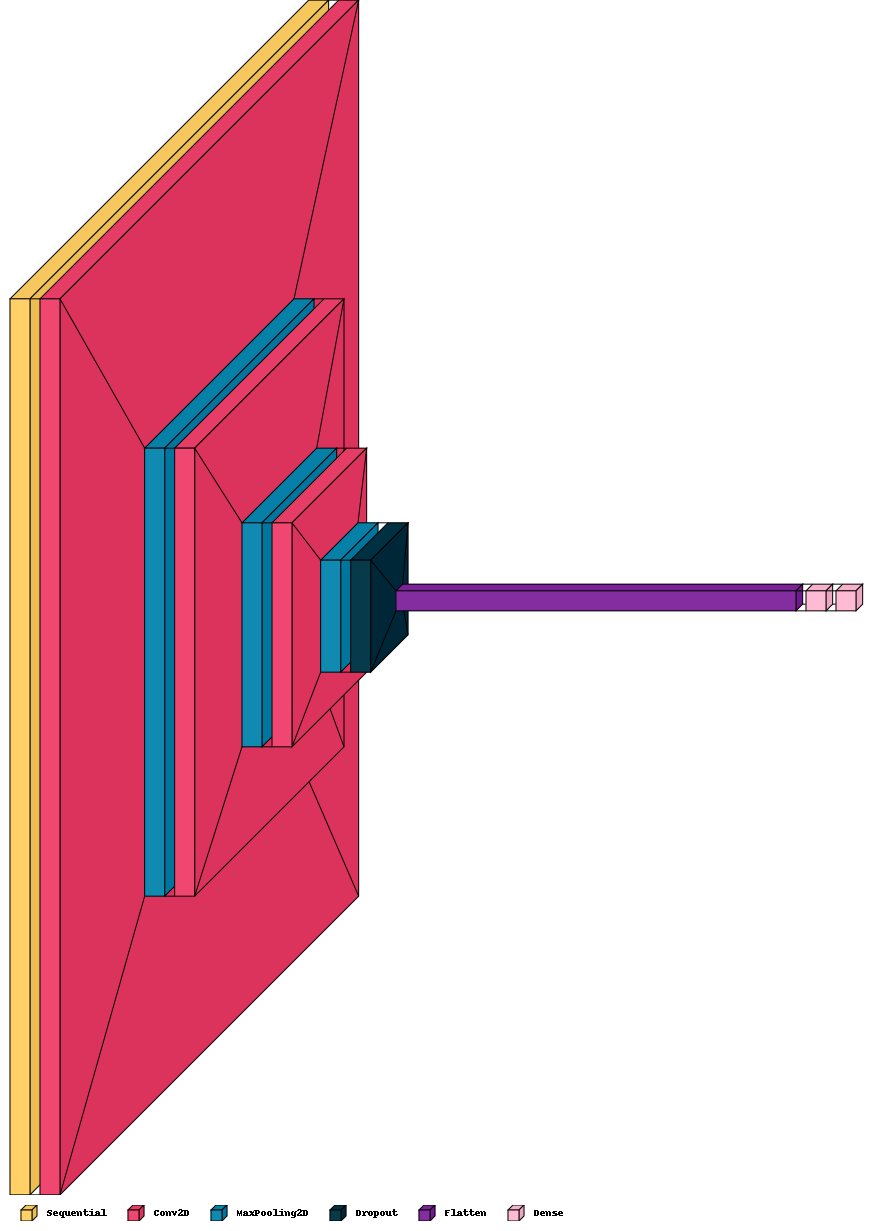

In [ ]:
! pip install visualkeras

import visualkeras
visualkeras.layered_view(model_1, legend=True)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/best_model_padi_lion.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_best_only=True,
                                      monitor='val_accuracy',  # Bisa disesuaikan dengan metrik yang ingin dipantau
                                      mode='max')

In [24]:
epochs=30
history_1 = model.fit(
  data_train,
  validation_data=data_test,
  epochs=epochs,
  callbacks=[checkpoint_callback]
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - accuracy: 0.4281 - loss: 1.2992 - val_accuracy: 0.6510 - val_loss: 0.8681
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5665 - loss: 1.0665 - val_accuracy: 0.6567 - val_loss: 0.8966
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.5821 - loss: 1.0514 - val_accuracy: 0.6529 - val_loss: 0.8174
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6383 - loss: 0.9515 - val_accuracy: 0.6623 - val_loss: 0.8468
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6380 - loss: 0.9472 - val_accuracy: 0.6660 - val_loss: 0.8027
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6216 - loss: 0.9502 - val_accuracy: 0.6886 - val_loss: 0.7960
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6432 - loss: 0.8998 - val_accuracy: 0.6717 - val_loss: 0.7665
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6545 - loss: 0.8952 - val_accuracy: 0.6867 -

In [25]:
# Menemukan epoch dengan nilai akurasi validasi tertinggi dan loss validasi terendah
best_epoch_accuracy = np.argmax(history_1.history['val_accuracy'])
best_val_accuracy = history_1.history['val_accuracy'][best_epoch_accuracy]

best_epoch_loss = np.argmin(history_1.history['val_loss'])
best_val_loss = history_1.history['val_loss'][best_epoch_loss]

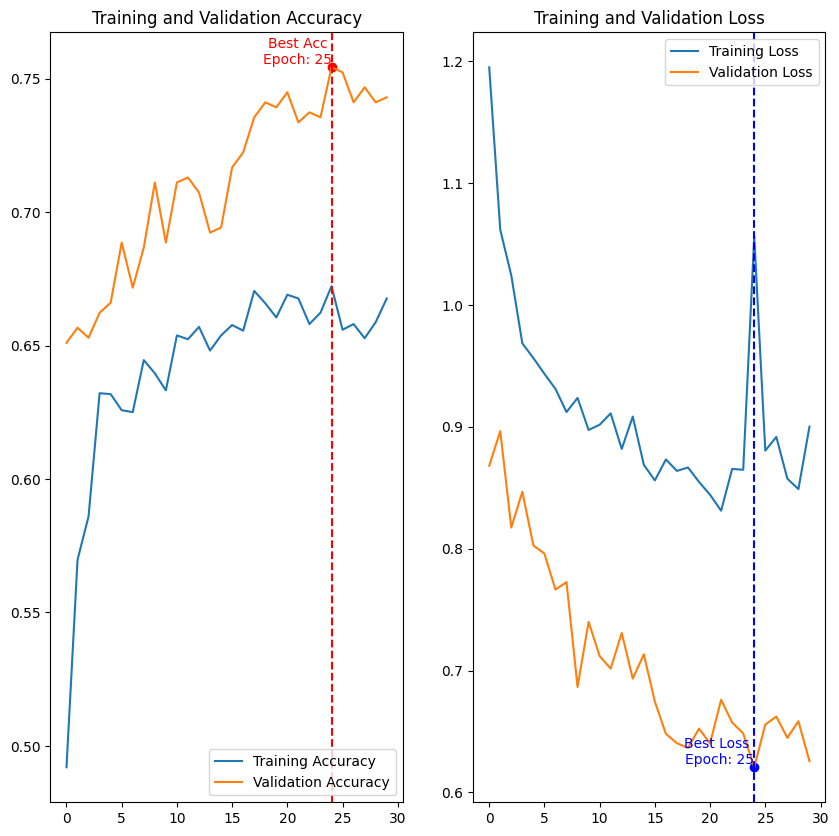

In [26]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Acc Epoch: {best_epoch_accuracy + 1} ')
plt.scatter(best_epoch_accuracy, best_val_accuracy, color='red')  # Menandai titik nilai akurasi tertinggi
plt.text(best_epoch_accuracy, best_val_accuracy, f'Best Acc \nEpoch: {best_epoch_accuracy + 1}',
         verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=10)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.axvline(x=best_epoch_loss, color='b', linestyle='--', label=f'Best Loss Epoch: {best_epoch_loss + 1} ')
plt.scatter(best_epoch_loss, best_val_loss, color='blue')  # Menandai titik nilai loss terendah
plt.text(best_epoch_loss, best_val_loss, f'Best Loss \nEpoch: {best_epoch_loss + 1}',
         verticalalignment='bottom', horizontalalignment='right', color='blue', fontsize=10)
plt.title('Training and Validation Loss')
plt.show()

In [27]:
num_classes = len(class_names)

model2 = Sequential([
  data_augmentation,
  MobileNetV3Large,
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
  layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.5),
  #MobileNetV3Small,
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  #layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath2 = '/content/best_model_padi_adam.keras'
checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_best_only=True,
                                      monitor='val_accuracy',  # Bisa disesuaikan dengan metrik yang ingin dipantau
                                      mode='max')

In [31]:
epochs=30
history_2 = model2.fit(
  data_train,
  validation_data=data_test,
  epochs=epochs,
  callbacks=[checkpoint_callback2]
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.4383 - loss: 1.4136 - val_accuracy: 0.6529 - val_loss: 0.8665
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5773 - loss: 1.0273 - val_accuracy: 0.6623 - val_loss: 0.8029
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6025 - loss: 0.9627 - val_accuracy: 0.6754 - val_loss: 0.7950
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.6211 - loss: 0.9097 - val_accuracy: 0.7054 - val_loss: 0.6980
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6471 - loss: 0.8955 - val_accuracy: 0.7392 - val_loss: 0.6625
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6639 - loss: 0.8738 - val_accuracy: 0.7411 - val_loss: 0.6527
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.6437 - loss: 0.8834 - val_accuracy: 0.7505 - val_loss: 0.6257
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6652 - loss: 0.8407 - val_accuracy: 0.7486 - 

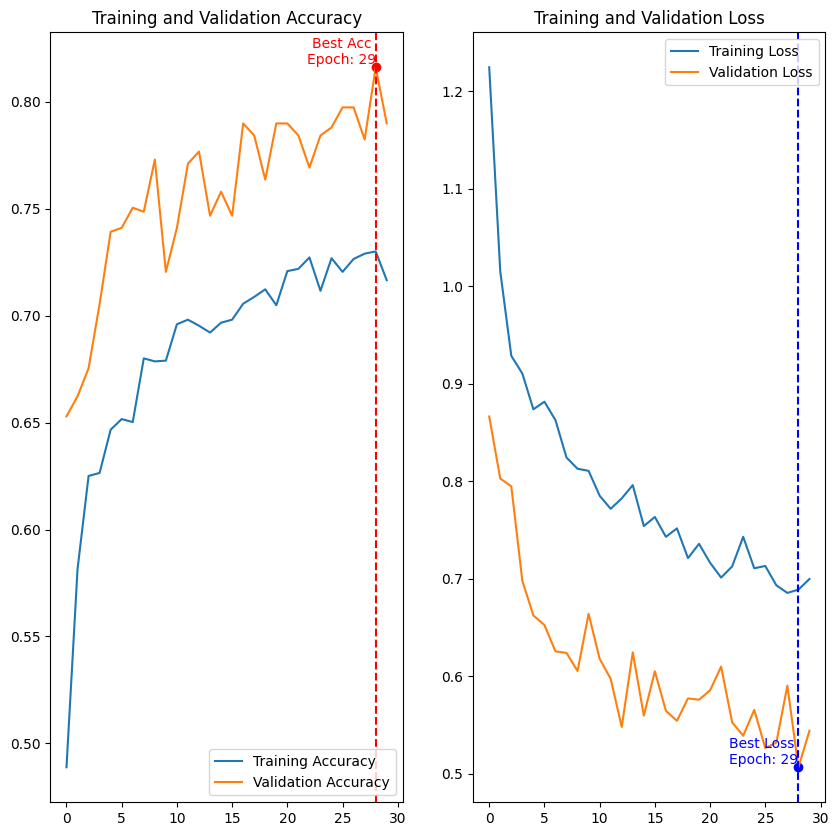

In [32]:
# Menemukan epoch dengan nilai akurasi validasi tertinggi dan loss validasi terendah
best_epoch_accuracy = np.argmax(history_2.history['val_accuracy'])
best_val_accuracy = history_2.history['val_accuracy'][best_epoch_accuracy]

best_epoch_loss = np.argmin(history_2.history['val_loss'])
best_val_loss = history_2.history['val_loss'][best_epoch_loss]

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Acc Epoch: {best_epoch_accuracy + 1} ')
plt.scatter(best_epoch_accuracy, best_val_accuracy, color='red')  # Menandai titik nilai akurasi tertinggi
plt.text(best_epoch_accuracy, best_val_accuracy, f'Best Acc \nEpoch: {best_epoch_accuracy + 1}',
         verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=10)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.axvline(x=best_epoch_loss, color='b', linestyle='--', label=f'Best Loss Epoch: {best_epoch_loss + 1} ')
plt.scatter(best_epoch_loss, best_val_loss, color='blue')  # Menandai titik nilai loss terendah
plt.text(best_epoch_loss, best_val_loss, f'Best Loss \nEpoch: {best_epoch_loss + 1}',
         verticalalignment='bottom', horizontalalignment='right', color='blue', fontsize=10)
plt.title('Training and Validation Loss')
plt.show()

In [33]:
num_classes = len(class_names)

model3 = Sequential([
  data_augmentation,
  MobileNetV3Large,
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
  layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.5),
  #MobileNetV3Small,
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  #layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
model3.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 32)            │         276,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,110 (14.65 MB)

 Trainable params: 3,253,204 (12.41 MB)

 Non-trainable params: 24,400 (95.31 KB)

 Optimizer params: 562,506 (2.15 MB)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath3 = '/content/best_model_padi_rmsprop.keras'
checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath3,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max')

In [36]:
epochs=30
history_3 = model3.fit(
  data_train,
  validation_data=data_test,
  epochs=epochs,
  callbacks=[checkpoint_callback3]
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.4366 - loss: 1.5564 - val_accuracy: 0.6004 - val_loss: 0.9845
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5856 - loss: 1.0443 - val_accuracy: 0.6154 - val_loss: 0.9043
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6168 - loss: 0.9720 - val_accuracy: 0.6811 - val_loss: 0.8042
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6231 - loss: 0.9446 - val_accuracy: 0.6792 - val_loss: 0.7782
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6299 - loss: 0.9098 - val_accuracy: 0.7205 - val_loss: 0.7634
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6412 - loss: 0.8726 - val_accuracy: 0.7092 - val_loss: 0.7014
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6572 - loss: 0.8581 - val_accuracy: 0.7355 - val_loss: 0.7545
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6806 - loss: 0.8334 - val_accuracy: 0.7242 - 

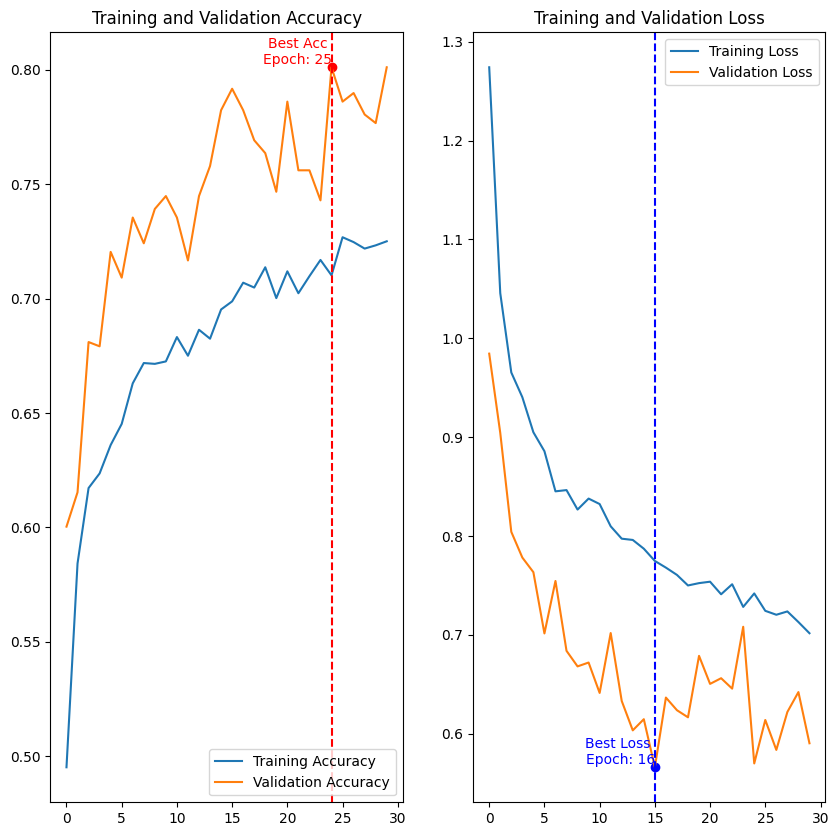

In [37]:
# Menemukan epoch dengan nilai akurasi validasi tertinggi dan loss validasi terendah
best_epoch_accuracy = np.argmax(history_3.history['val_accuracy'])
best_val_accuracy = history_3.history['val_accuracy'][best_epoch_accuracy]

best_epoch_loss = np.argmin(history_3.history['val_loss'])
best_val_loss = history_3.history['val_loss'][best_epoch_loss]

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Acc Epoch: {best_epoch_accuracy + 1} ')
plt.scatter(best_epoch_accuracy, best_val_accuracy, color='red')  # Menandai titik nilai akurasi tertinggi
plt.text(best_epoch_accuracy, best_val_accuracy, f'Best Acc \nEpoch: {best_epoch_accuracy + 1}',
         verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=10)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.axvline(x=best_epoch_loss, color='b', linestyle='--', label=f'Best Loss Epoch: {best_epoch_loss + 1} ')
plt.scatter(best_epoch_loss, best_val_loss, color='blue')  # Menandai titik nilai loss terendah
plt.text(best_epoch_loss, best_val_loss, f'Best Loss \nEpoch: {best_epoch_loss + 1}',
         verticalalignment='bottom', horizontalalignment='right', color='blue', fontsize=10)
plt.title('Training and Validation Loss')
plt.show()

In [38]:
loss, accuracy=model.evaluate(data_test)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7391 - loss: 0.6169
Accuracy:0.7429643273353577
Loss:0.625706136226654


In [39]:
loss2, accuracy2=model2.evaluate(data_test)
print(f"Accuracy:{accuracy2}")
print(f"Loss:{loss2}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8098 - loss: 0.5420
Accuracy:0.7898686528205872
Loss:0.5442215800285339


In [40]:
loss3, accuracy3=model3.evaluate(data_test)
print(f"Accuracy:{accuracy3}")
print(f"Loss:{loss3}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8087 - loss: 0.5905
Accuracy:0.801125705242157
Loss:0.5903009176254272


# **Testing**

In [41]:
x_val=[]
y_val=[]


for image, label in data_test:
    x_val.extend(image.numpy())
    y_val.extend(label.numpy())

In [42]:
preds=model3.predict(np.array(x_val))
y_pred_aug = np.argmax(preds, axis=1)


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step


F1-Score:[0.7873421652813929]
Precision:[0.779465590209558]
Recall:[0.8024547967630272]
Classification_Report
-----------------------
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       102
           1       0.81      0.89      0.85       198
           2       0.79      0.62      0.69       106
           3       0.77      0.83      0.80       127

    accuracy                           0.80       533
   macro avg       0.80      0.78      0.79       533
weighted avg       0.80      0.80      0.80       533

Confusion_Matrix
----------------------


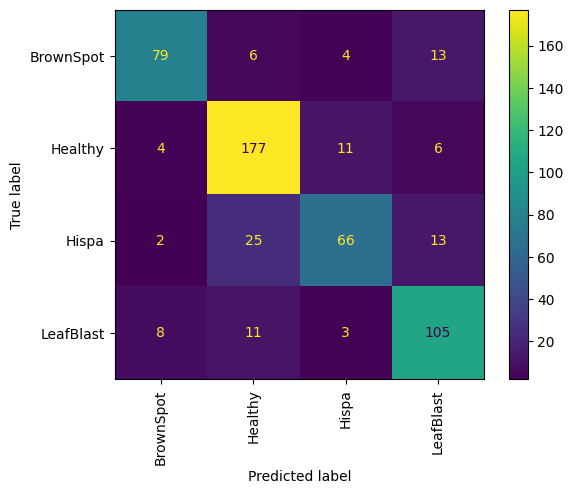

In [43]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report

f1_scores=[]
precision_scores=[]
recall_scores=[]

f1_scores.append(f1_score(y_pred_aug, y_val, average="macro"))
precision_scores.append(precision_score(y_pred_aug, y_val, average="macro"))
recall_scores.append(recall_score(y_pred_aug, y_val, average="macro"))


# Print the Results
print(f"F1-Score:{f1_scores}")
print(f"Precision:{precision_scores}")
print(f"Recall:{recall_scores}")



print("Classification_Report")
print("-----------------------")
print(classification_report(y_val,y_pred_aug))
print("Confusion_Matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_aug, display_labels=class_names, xticks_rotation="vertical")
plt.show()

## **Percobaan model dengan gambar**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image most likely belongs to BrownSpot.


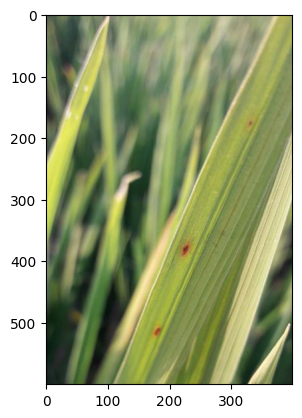

In [44]:
test_dirr = "/content/brownsspot.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image most likely belongs to LeafBlast.


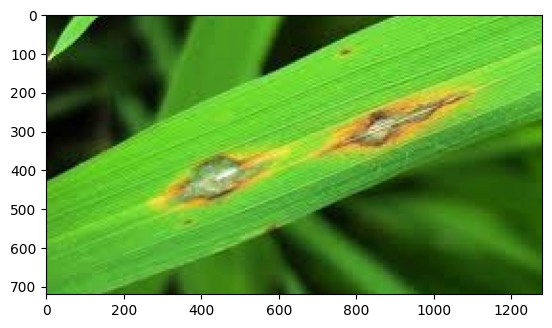

In [49]:
test_dirr = "/content/leafblast1.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
This image most likely belongs to Healthy


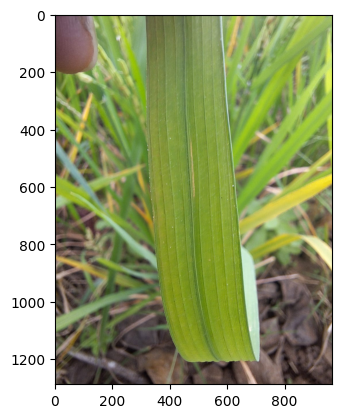

In [51]:
test_dirr = "/content/obs1.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This image most likely belongs to Healthy


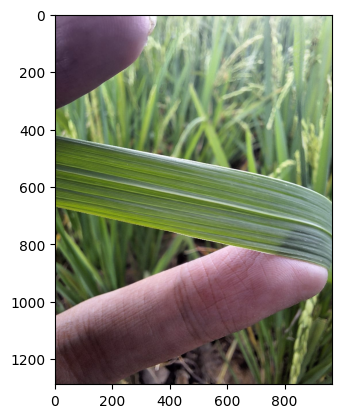

In [52]:
test_dirr = "/content/obs2.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# **Deployment**

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, 'padi.hdf5')
print("Model Saved")

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

with open("modelpadiurab.tflite", "wb") as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpvi42gyoq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_227')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137778340533648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778340538400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778340539984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778340539456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778340538752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778340543504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778332631280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778332633216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778332632512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778332633392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1377783326